# Deep tabular component predictions explanations by SHAP

In this notebook we will train a Deep Tabular model and intepret the results using SHAP.
**Focus** of this notebook is not performance or the models themselves, only how to integrate SHAP with trained models from the library.

## **[DISCLAIMER]**

Currently, only standalone deeptabular model is explainable, ie. interpretable by SHAP. SHAP can not use dictionaries as input, only numpy or tensor arrays. Complex models, like models that include wide **AND** deep model component use datasets in the form of dictionaries to separate dataset values for each part of the whole model. The resulting prediction is combined in Trainer.predict() method of the Trainer. SHAP works only with pure pytorch models, ie. use their implicit forward method - model(). After the model training using Trainer we need to extract deeptabular component of the model from the Trainer - ie. trained deeptabular model, and in case of classification objective append sigmoid/softmax layer, as these are included in Trainer.predict() method. For thorough understanding of the code we encourage users to check the trainer.predict() code in the library.

In [1]:
from typing import Tuple, Optional, Union, Literal
import shap
from copy import copy, deepcopy
import numpy as np
import torch
from torch import nn

from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.training import Trainer
from pytorch_widedeep.models import TabMlp, WideDeep
from pytorch_widedeep import datasets
from pytorch_widedeep.plotting import explainer
from importlib import reload

from sklearn.preprocessing import LabelEncoder

# Load datasets

**Regression toy dataset**

In [2]:
data_reg = datasets.load_california_housing(as_frame=True)

**Binary toy dataset**

In [3]:
data_binary = datasets.load_adult(as_frame=True)
data_binary["income"] = LabelEncoder().fit_transform(data_binary["income"].values)

**Multiclass toy dataset**

In [4]:
data_multiclass = datasets.load_ecoli(as_frame=True)
# drop low count classes
low_count_classes = data_multiclass["class"].value_counts()
data_multiclass = data_multiclass[data_multiclass["class"].isin(low_count_classes[low_count_classes<6].index.values) == False]
data_multiclass.reset_index(drop=True, inplace=True)
data_multiclass["class"] = LabelEncoder().fit_transform(data_multiclass["class"].values)
# drop identifier as we do not need it in this example
data_multiclass.drop(columns=["SequenceName"], inplace=True)

# Data preparation

### Preparing the data

**Regression toy dataset**

In [5]:
# deeptabular
tab_preprocessor_reg = TabPreprocessor(
    embed_cols=None,
    continuous_cols=[
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "Latitude",
        "Longitude"
    ],
)
X_tab_reg = tab_preprocessor_reg.fit_transform(data_reg)

**Binary toy dataset**

In [6]:
tab_preprocessor_binary = TabPreprocessor(
    embed_cols=[
        "workclass",
        "fnlwgt",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "gender",
        "native-country"
    ],
    continuous_cols=[
        "age",
        "educational-num",
        "capital-gain",
        "capital-loss",
        "hours-per-week"
    ],
)
X_tab_binary = tab_preprocessor_binary.fit_transform(data_binary)


**Multiclass toy dataset**

In [7]:

tab_preprocessor_multiclass = TabPreprocessor(
    embed_cols=None,
    continuous_cols=[
        "mcg",
        "gvh",
        "lip",
        "chg",
        "aac",
        "alm1",
        "alm2"
    ],
)
X_tab_multiclass = tab_preprocessor_multiclass.fit_transform(data_multiclass)

**Targets**

In [8]:
target_reg = data_reg["MedHouseVal"].values
target_binary = data_binary["income"].values
target_multiclass = data_multiclass["class"].values

### Define the models

**Regression model**

In [9]:
tab_mlp_reg = TabMlp(
    column_idx=tab_preprocessor_reg.column_idx,
    cat_embed_input=None,
    cat_embed_dropout=0.1,
    continuous_cols=tab_preprocessor_reg.continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
wd_model_reg = WideDeep(deeptabular=tab_mlp_reg)

**Binary model**

In [10]:
tab_mlp_binary = TabMlp(
    column_idx=tab_preprocessor_binary.column_idx,
    cat_embed_input=tab_preprocessor_binary.cat_embed_input,
    cat_embed_dropout=0.1,
    continuous_cols=tab_preprocessor_binary.continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
wd_model_binary = WideDeep(deeptabular=tab_mlp_binary)

**Multiclass model**

In [11]:

tab_mlp_multiclass = TabMlp(
    column_idx=tab_preprocessor_multiclass.column_idx,
    cat_embed_input=None,
    cat_embed_dropout=0.1,
    continuous_cols=tab_preprocessor_multiclass.continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",
)
wd_model_multiclass = WideDeep(deeptabular=tab_mlp_multiclass, pred_dim=len(np.unique(target_multiclass)))

## Train the models

**Regression trainer**

In [12]:
tab_trainer_reg = Trainer(
    model=wd_model_reg,
    objective="regression",
    optimizers=torch.optim.AdamW(wd_model_reg.parameters(), lr=0.001),
)
tab_trainer_reg.fit(X_tab=X_tab_reg, target=target_reg, n_epochs=4, batch_size=128, val_split=0.2)

valid: 100%|██████████| 33/33 [00:00<00:00, 70.50it/s, loss=0.719]


**Binary trainer**

In [13]:
tab_trainer_binary = Trainer(
    model=wd_model_binary,
    objective="binary",
    optimizers=torch.optim.AdamW(wd_model_binary.parameters(), lr=0.001),
)
tab_trainer_binary.fit(X_tab=X_tab_binary, target=target_binary, n_epochs=4, batch_size=128, val_split=0.2)

valid: 100%|██████████| 77/77 [00:01<00:00, 44.58it/s, loss=0.363]


**Multiclass trainer**

In [15]:
tab_trainer_multiclass = Trainer(
    model=wd_model_multiclass,
    objective="multiclass",
    optimizers=torch.optim.AdamW(wd_model_multiclass.parameters(), lr=0.001),
)
tab_trainer_multiclass.fit(X_tab=X_tab_multiclass, target=target_multiclass, n_epochs=4, batch_size=128, val_split=0.2)

valid: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=0.595]


# SHAP - predictions explanations
Force and decision plots serve same purpose, but force plots require javascript for rendering and can't handle multioutput models, eg. multiclass classification models. Therefore, we focus on decision and not force plots.

## **[DISCLAIMER]**
We encourage users to use model agnostic Kernel or Gradient Explainer as they yield more accurate results in the presented examples as Deep Explainer. Our claim is supported by provided GitHub issues.

## Kernel Explainer
Kernel explainer expects prediction function and numpy ndarray input type. Kernel explainer also uses notion of random background samples that are used for the explanation of the predictions.

As random background samples we simply use samples 50 random samples from the training dataset and explain 1st sample from the dataset. In real use case we encourage users to train/valid/test split data and use validation dataset as background samples.

For more information about Kernel Eplainer please read SHAP documentation or related [paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf).

**Regression model explainer**

predict: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

predict: 100%|██████████| 100/100 [00:04<00:00, 23.00it/s]


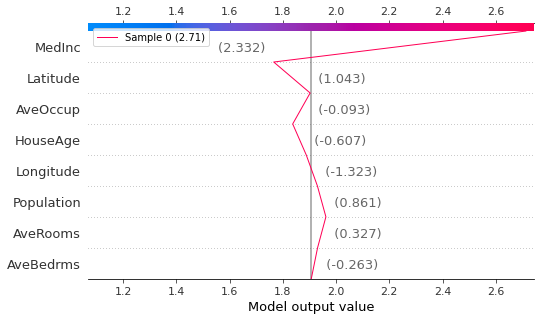

In [46]:
reg_explainer = explainer.ShapExplainer()
reg_explainer.fit(tab_trainer=tab_trainer_reg, X_tab_train=X_tab_reg, explainer_type="kernel")
reg_explainer.explain_decision_plot(X_tab_explain=X_tab_reg[1], feature_names=list(tab_preprocessor_reg.column_idx))

**Binary model explainer**

predict: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

predict: 100%|██████████| 811/811 [00:12<00:00, 66.75it/s]


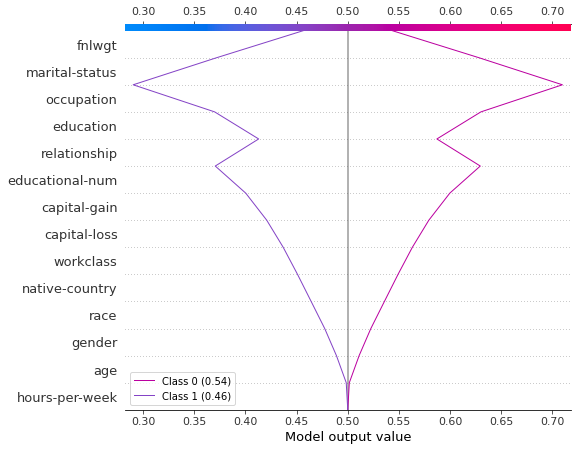

In [19]:
binary_explainer = explainer.ShapExplainer()
binary_explainer.fit(tab_trainer=tab_trainer_binary, X_tab_train=X_tab_binary, explainer_type="kernel")
binary_explainer.explain_decision_plot(X_tab_explain=X_tab_binary[1], feature_names=list(tab_preprocessor_binary.column_idx))

**Multiclass model explainer**

predict: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

predict: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


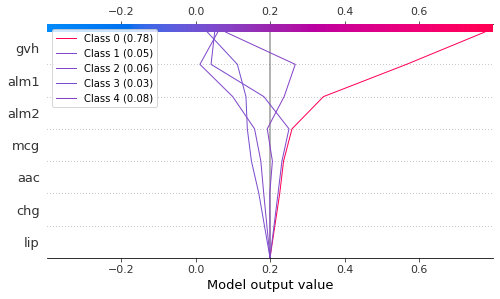

In [21]:
multiclass_explainer = explainer.ShapExplainer()
multiclass_explainer.fit(tab_trainer=tab_trainer_multiclass, X_tab_train=X_tab_multiclass, explainer_type="kernel")
multiclass_explainer.explain_decision_plot(X_tab_explain=X_tab_multiclass[0], feature_names=list(tab_preprocessor_multiclass.column_idx))

## Deep Explainer (DeepLift + LIME)

Deep explainer expects model(Keras, Tensorflow or PyTorch) and Tensor input type. Deep explainer also uses notion of random background samples that are used for the explanation of the predictions.

As random background samples we simply use samples 50 random samples from the training dataset and explain 1st sample from the dataset. In real use case we encourage users to train/valid/test split data and use validation dataset as background samples.

For more information about Deep Explainer please read SHAP [documentation](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models).

### **[DISCLAIMER]**
Use of DeepExplainer with pytorch_widedeep is supported, but we discourage users from doing so as in the upcoming examples you may see that computed SHAP and explainer.exptected_value does not sum up to predicted value of the model. This issue was already reported, see:
* [DeepExplainer Shap sums do not add up to model prediction](https://github.com/slundberg/shap/issues/1550)
* [Mismatch between force_plot() output from DeepExplainer and actual model's output](https://github.com/slundberg/shap/issues/1678)

This is partially pointed out in the SHAP documentation ["high-speed approximation algorithm for SHAP values"](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models).

**Regression model explainer**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


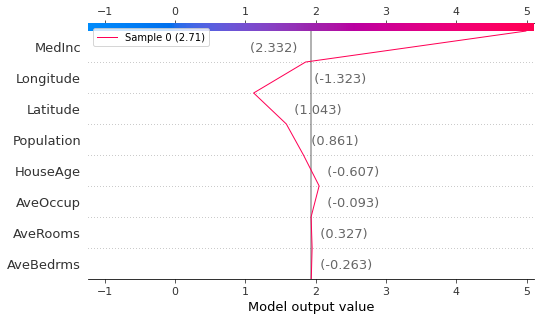

In [50]:
reg_explainer = explainer.ShapExplainer()
reg_explainer.fit(tab_trainer=tab_trainer_reg, X_tab_train=X_tab_reg, explainer_type="deep")
reg_explainer.explain_decision_plot(X_tab_explain=X_tab_reg[1], feature_names=list(tab_preprocessor_reg.column_idx))

**Binary model explainer**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


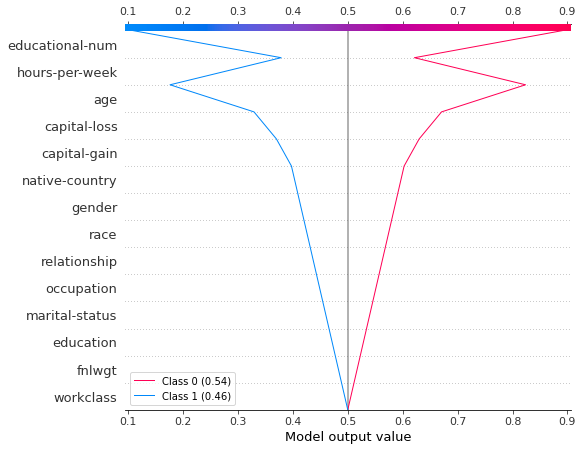

In [23]:
binary_explainer = explainer.ShapExplainer()
binary_explainer.fit(tab_trainer=tab_trainer_binary, X_tab_train=X_tab_binary, explainer_type="deep")
binary_explainer.explain_decision_plot(X_tab_explain=X_tab_binary[1], feature_names=list(tab_preprocessor_binary.column_idx))

**Multiclass model explainer**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


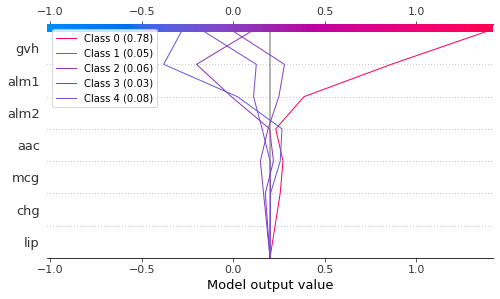

In [25]:
multiclass_explainer = explainer.ShapExplainer()
multiclass_explainer.fit(tab_trainer=tab_trainer_multiclass, X_tab_train=X_tab_multiclass, explainer_type="deep")
multiclass_explainer.explain_decision_plot(X_tab_explain=X_tab_multiclass[0], feature_names=list(tab_preprocessor_multiclass.column_idx))

## Gradient Explainer (Integrated Gradients, SHAP, and SmoothGrad)

Gradient Explainer expects model(Keras, Tensorflow or PyTorch) and Tensor input type. Gradient explainer also uses notion of background samples that are used for the explanation of the predictions.

As random background samples we use all samples from the training dataset and explain 1st sample from it. In real use case we encourage users to train/valid/test split data and use validation dataset as background samples.

For more information about Gradient Explainer please read SHAP [documentation](https://github.com/slundberg/shap#deep-learning-example-with-gradientexplainer-tensorflowkeraspytorch-models).

### **[DISCLAIMER]**
Use of DeepExplainer with pytorch_widedeep is supported, the resulting approximation in following examples are better than with DeepExplainer but we discourage users from doing so as in the upcoming examples you may see that computed SHAP and explainer.exptected_value does not sum up to predicted value of the model in the binary classification scenario. This issue was already reported, see:
* [expected value missing](https://github.com/slundberg/shap/issues/865)

#### Solution
We had to make small adjustment to the code which we marked by following warning message:
```
WARNING:
This is not a native functionality of the current version of SHAP.
According to SHAP code '(commented out because self.data could be huge for GradientExpliner)', see:
https://github.com/slundberg/shap/blob/895a796b20cb2ab6b158a4cd4326d8f4d00ca615/shap/explainers/_gradient.py#L165,
we use same expected value calculation as used in DeepExplainer pytorch implementation, see:
https://github.com/slundberg/shap/blob/895a796b20cb2ab6b158a4cd4326d8f4d00ca615/shap/explainers/_deep/deep_pytorch.py#L53
```

**Regression model explainer**

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


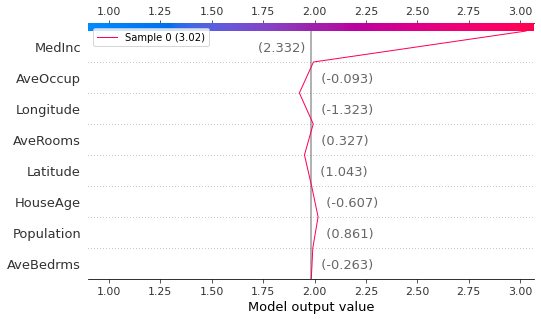

In [32]:
reg_explainer = explainer.ShapExplainer()
reg_explainer.fit(tab_trainer=tab_trainer_reg, X_tab_train=X_tab_reg, explainer_type="gradient")
reg_explainer.explain_decision_plot(X_tab_explain=X_tab_reg[1], feature_names=list(tab_preprocessor_reg.column_idx))

**Binary model explainer**


            according to SHAP code '(commented out because self.data could be huge for GradientExpliner)', see:
            https://github.com/slundberg/shap/blob/895a796b20cb2ab6b158a4cd4326d8f4d00ca615/shap/explainers/_gradient.py#L165,
            we use same expected value calculation as used in DeepExplainer pytorch implementation, see:
            https://github.com/slundberg/shap/blob/895a796b20cb2ab6b158a4cd4326d8f4d00ca615/shap/explainers/_deep/deep_pytorch.py#L53
`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


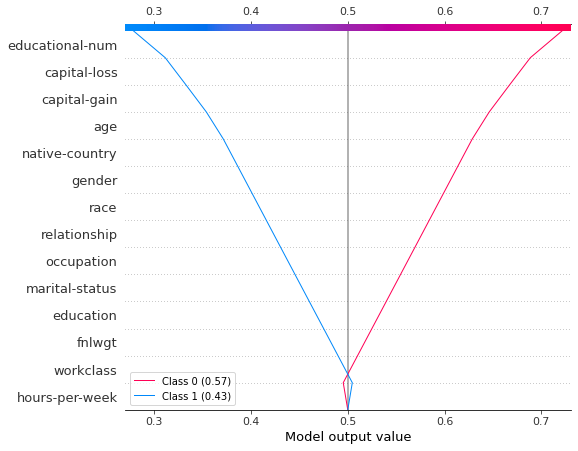

In [33]:
binary_explainer = explainer.ShapExplainer()
binary_explainer.fit(tab_trainer=tab_trainer_binary, X_tab_train=X_tab_binary, explainer_type="gradient")
binary_explainer.explain_decision_plot(X_tab_explain=X_tab_binary[1], feature_names=list(tab_preprocessor_binary.column_idx))

**Multiclass model explainer**


            according to SHAP code '(commented out because self.data could be huge for GradientExpliner)', see:
            https://github.com/slundberg/shap/blob/895a796b20cb2ab6b158a4cd4326d8f4d00ca615/shap/explainers/_gradient.py#L165,
            we use same expected value calculation as used in DeepExplainer pytorch implementation, see:
            https://github.com/slundberg/shap/blob/895a796b20cb2ab6b158a4cd4326d8f4d00ca615/shap/explainers/_deep/deep_pytorch.py#L53
`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


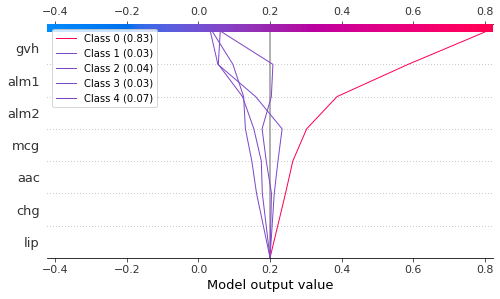

In [34]:
multiclass_explainer = explainer.ShapExplainer()
multiclass_explainer.fit(tab_trainer=tab_trainer_multiclass, X_tab_train=X_tab_multiclass, explainer_type="gradient")
multiclass_explainer.explain_decision_plot(X_tab_explain=X_tab_multiclass[0], feature_names=list(tab_preprocessor_multiclass.column_idx))